# Phenotype acronym extraction

In [26]:
%load_ext autoreload
%autoreload 2

import sys
import cPickle
import numpy as np

# import snorkel and gwasdb
sys.path.append('../snorkel')
sys.path.append('../src')
sys.path.append('../src/crawler')

# set up paths
abstract_dir = '../data/db/papers'

# set up matplotlib
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,4)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load corpus

In [27]:
from snorkel.parser import XMLDocParser
from extractor.parser import UnicodeXMLTableDocParser

xml_parser = UnicodeXMLTableDocParser(
    path=abstract_dir,
    doc='./*',
    text='.//table',
    id='.//article-id[@pub-id-type="pmid"]/text()',
    keep_xml_tree=True)

In [28]:
from snorkel.parser import CorpusParser, OmniParser
import cPickle

table_parser = OmniParser()

corpus_name = 'gwas-table-corpus.pkl'
try:
    with open(corpus_name,"r") as pkl:
        corpus = cPickle.load(pkl)
except:
    cp = CorpusParser(xml_parser, table_parser, max_docs=15)
    %time corpus = cp.parse_corpus(name='GWAS Corpus')
    # pickling currently doesn't work...
#     with open(corpus_name,"w") as pkl:
#         corpus = cPickle.dump(corpus, pkl)

CPU times: user 54.7 s, sys: 2.99 s, total: 57.7 s
Wall time: 1min 24s


## Candidate extraction

### From tables

In [29]:
from snorkel.matchers import DictionaryMatch, Union, CellNameMatcher, CellDictNameMatcher
from snorkel.candidates import EntityExtractor
from snorkel.candidates import TableNgrams, CellSpace

# Define a candidate space
cells = CellSpace()

# Create a list of possible words that could denote phenotypes
acro_words = ['abbreviation', 'acronym']
phen_words = ['trait', 'phenotype']

# Define matchers
phen_matcher = CellDictNameMatcher(axis='col', d=phen_words, n_max=3, ignore_case=True)
acro_matcher = CellDictNameMatcher(axis='col', d=acro_words, n_max=3, ignore_case=True)

phen_extractor = EntityExtractor(cells, phen_matcher)
acro_extractor = EntityExtractor(cells, acro_matcher)

In [30]:
from snorkel.candidates import AlignedTableRelationExtractor
relation_extractor = AlignedTableRelationExtractor(phen_extractor, acro_extractor, axis='row', induced=False)
tables = corpus.get_tables()

In [31]:
%time candidates = relation_extractor.extract(tables, name='all')
table_c = candidates
print "%s relations extracted, e.g." % len(table_c)
for cand in table_c[:5]: 
    print cand

CPU times: user 23min 2s, sys: 11.2 s, total: 23min 13s
Wall time: 23min 20s
58 relations extracted, e.g.
SpanPair(Span("CD40 Ligand, serum & plasma", context=None, chars=[0,26], words=[0,5]), Span("CD40L", context=None, chars=[0,4], words=[0,0]))
SpanPair(Span("2", context=None, chars=[0,0], words=[0,0]), Span("CD40L", context=None, chars=[0,4], words=[0,0]))
SpanPair(Span("C-reactive protein", context=None, chars=[0,17], words=[0,1]), Span("CRP", context=None, chars=[0,2], words=[0,0]))
SpanPair(Span("5", context=None, chars=[0,0], words=[0,0]), Span("CRP", context=None, chars=[0,2], words=[0,0]))
SpanPair(Span("Intercellular adhesion molecule-1", context=None, chars=[0,32], words=[0,2]), Span("ICAM1", context=None, chars=[0,4], words=[0,0]))


In [349]:
for cand in table_c[:5]: 
    print cand.span0.context.table, cand

Table('17903293', 0) SpanPair(Span("CD40 Ligand, serum & plasma", context=None, chars=[0,26], words=[0,5]), Span("CD40L", context=None, chars=[0,4], words=[0,0]))
Table('17903293', 0) SpanPair(Span("2", context=None, chars=[0,0], words=[0,0]), Span("CD40L", context=None, chars=[0,4], words=[0,0]))
Table('17903293', 0) SpanPair(Span("C-reactive protein", context=None, chars=[0,17], words=[0,1]), Span("CRP", context=None, chars=[0,2], words=[0,0]))
Table('17903293', 0) SpanPair(Span("5", context=None, chars=[0,0], words=[0,0]), Span("CRP", context=None, chars=[0,2], words=[0,0]))
Table('17903293', 0) SpanPair(Span("Intercellular adhesion molecule-1", context=None, chars=[0,32], words=[0,2]), Span("ICAM1", context=None, chars=[0,4], words=[0,0]))


### From text

In [350]:
from snorkel.parser import SentenceParser, CorpusParser
from extractor.parser import UnicodeXMLDocParser, GWASXMLDocParser

xml_parser = GWASXMLDocParser(
    path=abstract_dir,
    doc='./*',
    title='.//front//article-title//text()',
    abstract='.//abstract//p//text()',
    n_par=5,
    id='.//article-id[@pub-id-type="pmid"]/text()',
    keep_xml_tree=True)

sent_parser = SentenceParser()
cp = CorpusParser(xml_parser, sent_parser, max_docs=15)
%time text_corpus = cp.parse_corpus(name='GWAS Text Corpus')

CPU times: user 882 ms, sys: 128 ms, total: 1.01 s
Wall time: 6.58 s


In [351]:
from snorkel.candidates import Ngrams, CellSpace, TableNgrams
from snorkel.matchers import RegexMatchSpan
from snorkel.candidates import EntityExtractor, RelationExtractor, UnionExtractor

# Define a candidate space
ngrams6 = Ngrams(n_max=6)
ngrams3 = Ngrams(n_max=3)
cells = CellSpace()
table_ngrams3 = TableNgrams(n_max=3)

# Define matchers
phen_matcher = RegexMatchSpan(rgx=r'.+ \([a-zA-Z-]{1,5}[0-9]{0,2}[\);]')
acro_matcher = RegexMatchSpan(rgx=r'\([a-zA-Z-]{1,5}[0-9]{0,2}[\);]')

# Extractors
phen_txt_ngram_extractor = EntityExtractor(ngrams6, phen_matcher)
phen_txt_cells_extractor = EntityExtractor(cells, phen_matcher)
acro_txt_ngram_extractor = EntityExtractor(ngrams3, acro_matcher)
acro_txt_cells_extractor = EntityExtractor(table_ngrams3, acro_matcher)

# Filtering functions
def overlap_filter_fn(span0, span1):
    if hasattr(span0.context, 'cell') and hasattr(span1.context, 'cell'):
        if span0.context.cell != span1.context.cell: return False
    if len(span0.get_span().split()) >= 15: return False
    start0, end0 = span0.char_start, span0.char_end
    start1, end1 = span1.char_start, span1.char_end
    return True if start0 <= start1 <= end1 <= end0 else False

# Relation extractor
txt_tab_ngram_extractor = RelationExtractor(phen_txt_ngram_extractor, acro_txt_ngram_extractor, filter_fn=overlap_filter_fn)
txt_tab_cells_extractor = RelationExtractor(phen_txt_cells_extractor, acro_txt_cells_extractor, filter_fn=overlap_filter_fn)

Extract acroynms from tables

In [352]:
%time txt_tab_c = txt_tab_ngram_extractor.extract(corpus.get_phrases(), name='all')
print len(txt_tab_c), 'candidates extracted from text in tables'

CPU times: user 997 ms, sys: 49.1 ms, total: 1.05 s
Wall time: 1.09 s
380 candidates extracted from text in tables


Extract acronyms from full table cells

In [353]:
%time txt_cel_c = txt_tab_cells_extractor.extract(corpus.get_tables(), name='all')
print len(txt_cel_c), 'candidates extracted from text in full table cells'

CPU times: user 980 ms, sys: 22.9 ms, total: 1 s
Wall time: 1.01 s
91 candidates extracted from text in full table cells


Extract acroynms from abstracts

In [354]:
%time txt_txt_c = txt_tab_ngram_extractor.extract(text_corpus.get_sentences(), name='all')
print len(txt_txt_c), 'candidates extracted from text in abstracts'

CPU times: user 2.55 s, sys: 39.3 ms, total: 2.59 s
Wall time: 2.74 s
438 candidates extracted from text in abstracts


## Learning the correctness of relations

In [264]:
from snorkel.candidates import UnionExtractor

contexts = [corpus.get_tables(), corpus.get_phrases(), text_corpus.get_sentences()]
extractors = [txt_tab_cells_extractor, txt_tab_ngram_extractor, txt_tab_ngram_extractor]
joint_extractor = UnionExtractor(extractor_list=extractors, context_list=contexts)
all_c = joint_extractor.union()
print len(all_c)

640


### Creating a gold set

To create a gold set, we save all extracted relations into a csv file. We annotate it manually, and save the result to a second file. It contains pairs of phenotype and rsid strings; if that file exists, we take these as gold truth.

In [355]:
# store relations to annotate
with open('acronyms.unannotated.tsv', 'w') as f:
    for span_pair in all_c:
        doc_id = span_pair.span0.context.document.name
        str1 = span_pair.span0.get_span()
        str2 = span_pair.span1.get_span()
        if (doc_id, str1, str2) not in K: 
            if hasattr(span_pair.span1.context, 'cell'):
                print span_pair.span0.context.cell.text
                print span_pair.span0.get_span()
                print (doc_id, str1, str2), LF_full_cell(span_pair)
                print 
        try:
            f.write('%s\t%s\t%s\n' % (doc_id, str1, str2))
        except:
            continue

Physical Position (bp)†
Physical Position (bp)
('17903294', u'Physical Position (bp)', u'(bp)') 0

Physical Position (bp)†
Physical Position (bp)
('17903294', u'Physical Position (bp)', u'(bp)') 0

GEE p-val (Rank)††
GEE p-val (Rank)
('17903294', u'GEE p-val (Rank)', u'(Rank)') 0

Physical Position (bp)†
Physical Position (bp)
('17903294', u'Physical Position (bp)', u'(bp)') 0

Physical Position (bp)†
Physical Position (bp)
('17903294', u'Physical Position (bp)', u'(bp)') 0

GEE Pval (Rank)††
GEE Pval (Rank)
('17903294', u'GEE Pval (Rank)', u'(Rank)') 0

Physical Position (bp)†
Physical Position (bp)
('17903294', u'Physical Position (bp)', u'(bp)') 0

Physical Position (bp)†
Physical Position (bp)
('17903294', u'Physical Position (bp)', u'(bp)') 0

Total Cerebral Brain Volume (ATCBV)
Total Cerebral Brain Volume (ATCBV)
('17903297', u'Total Cerebral Brain Volume (ATCBV)', u'(ATCBV)') 1

Factor 1:Verbal Memory (F1)
Factor 1:Verbal Memory (F1)
('17903297', u'Factor 1:Verbal Memory (F1)', 

We now load the results of our annotation

In [42]:
annotations = dict()
with open('acronyms.anotated.txt') as f:
    text = f.read()
    for line in text.split('\r'):
        doc_id, str1, str2, res = line.strip().split('\t')
        res = 1 if int(res) == 1 else -1
        annotations[(doc_id, str1, str2)] = res

### Classifying table acronyms

In [359]:
from snorkel.features import TableNgramPairFeaturizer

pkl_f = 'acro_table_feats.pkl'
try:
    with open(pkl_f, 'rb') as f:
        featurizer = cPickle.load(f)
except:
    featurizer = TableNgramPairFeaturizer()
    featurizer.fit_transform(candidates)

Building feature index...
Extracting features...
0/2579


In [360]:
def spair2uid(span_pair):
    doc_id = span_pair.span0.context.document.name
    str1 = span_pair.span0.get_span()
    str2 = span_pair.span1.get_span()
    return (doc_id, str1, str2)

# Split into train and test set
training_candidates = []
gold_candidates     = []
gold_labels         = []
n_half = len(candidates)/2
for c in candidates[:n_half]:
    uid = spair2uid(c)
    if uid in annotations:
        gold_candidates.append(c)
        gold_labels.append(annotations[uid])
    else:
        training_candidates.append(c)
training_candidates.extend(candidates[n_half:])
gold_labels = np.array(gold_labels)
print "Training set size: %s" % len(training_candidates)
print "Gold set size: %s" % len(gold_candidates)
print "Positive labels in training set: %s" % len([c for c in training_candidates if annotations.get(spair2uid(c),0)==1])
print "Negative labels in training set: %s" % len([c for c in training_candidates if annotations.get(spair2uid(c),0)==-1])
print "Positive labels in gold set: %s" % len([c for c in gold_candidates if annotations[spair2uid(c)]==1])
print "Negative labels in gold set: %s" % len([c for c in gold_candidates if annotations[spair2uid(c)]==-1])

Training set size: 30
Gold set size: 28
Positive labels in training set: 22
Negative labels in training set: 7
Positive labels in gold set: 14
Negative labels in gold set: 14


In [361]:
def LF1_digits(m):
    txt = m.span0.get_span()
    frac_num = len([ch for ch in txt if ch.isdigit()]) / float(len(txt))
    return -1 if frac_num > 0.5 else +1
def LF1_short(m):
    txt = m.span0.get_span()
    return -1 if len(txt) < 5 else 0

LF_tables = [LF1_digits, LF1_short]

In [362]:
from snorkel.snorkel import TrainingSet
from snorkel.features import NgramFeaturizer

training_set = TrainingSet(training_candidates, LF_tables, featurizer=TableNgramPairFeaturizer())

Applying LFs...
Featurizing...
Building feature index...
Extracting features...
0/1926
LF Summary Statistics: 2 LFs applied to 30 candidates
------------------------------------------------------------
Coverage (candidates w/ > 0 labels):		100.00%
Overlap (candidates w/ > 1 labels):		23.33%
Conflict (candidates w/ conflicting labels):	0.00%


array([[<matplotlib.axes.AxesSubplot object at 0x128baff90>]], dtype=object)

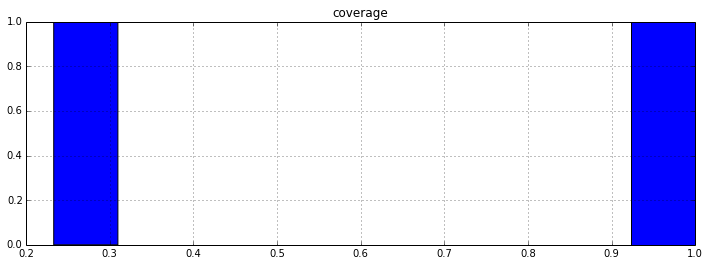

In [363]:
lf_stats = training_set.lf_stats()
lf_stats[:5]
lf_stats.hist("coverage")

In [364]:
from snorkel.snorkel import Learner
import snorkel.learning
from snorkel.learning import LogReg

learner = Learner(training_set, model=LogReg())

# Splitting into CV and test set
n_half = len(gold_candidates)/2
test_candidates = gold_candidates[:n_half]
test_labels     = gold_labels[:n_half]
cv_candidates   = gold_candidates[n_half:]
cv_labels       = gold_labels[n_half:]

from snorkel.learning_utils import GridSearch
gs       = GridSearch(learner, ['mu', 'lf_w0'], [[1e-5, 1e-7],[1.0,2.0]])
gs_stats = gs.fit(cv_candidates, cv_labels)

Testing mu = 1.00e-05, lf_w0 = 1.00e+00
Begin training for rate=0.01, mu=1e-05
	Learning epoch = 0	Gradient mag. = 0.030888
	Learning epoch = 250	Gradient mag. = 0.084110
	Learning epoch = 500	Gradient mag. = 0.211097
	Learning epoch = 750	Gradient mag. = 0.275662
Final gradient magnitude for rate=0.01, mu=1e-05: 0.282
Applying LFs...
Featurizing...
Testing mu = 1.00e-05, lf_w0 = 2.00e+00
Begin training for rate=0.01, mu=1e-05
	Learning epoch = 0	Gradient mag. = 0.061684
	Learning epoch = 250	Gradient mag. = 0.158546
	Learning epoch = 500	Gradient mag. = 0.277430
	Learning epoch = 750	Gradient mag. = 0.284230
Final gradient magnitude for rate=0.01, mu=1e-05: 0.294
Testing mu = 1.00e-07, lf_w0 = 1.00e+00
Begin training for rate=0.01, mu=1e-07
	Learning epoch = 0	Gradient mag. = 0.030888
	Learning epoch = 250	Gradient mag. = 0.084282
	Learning epoch = 500	Gradient mag. = 0.211653
	Learning epoch = 750	Gradient mag. = 0.275691
Final gradient magnitude for rate=0.01, mu=1e-07: 0.282
Testin

In [365]:
gs_stats

,mu,lf_w0,Prec.,Rec.,F1
0,0.00001,1,1,1,1
1,0.00001,2,1,1,1
2,0.00000,1,1,1,1
3,0.00000,2,1,1,1


In [366]:
learner.test_wmv(test_candidates, test_labels)

Applying LFs...
Featurizing...
Test set size:	14
----------------------------------------
Precision:	1.0
Recall:		1.0
F1 Score:	1.0
----------------------------------------
TP: 7 | FP: 0 | TN: 7 | FN: 0


In [367]:
preds = learner.predict_wmv(candidates)
resolved_acronyms = [spair2uid(c) for (c, p) in zip(candidates, preds) if p == 1]
print resolved_acronyms[:10]

Applying LFs...
Featurizing...
[('17903293', u'CD40 Ligand, serum & plasma', u'CD40L'), ('17903293', u'C-reactive protein', u'CRP'), ('17903293', u'Intercellular adhesion molecule-1', u'ICAM1'), ('17903293', u'Interleukin-6', u'IL6'), ('17903293', u'Urinary isoprostanes/creatinine', u'IsoCrUrine'), ('17903293', u'Monocyte chemoattractant protein-1', u'MCP1'), ('17903293', u'Myeloperoxidase', u'MPO'), ('17903293', u'Osteoprotegerin', u'OPG'), ('17903293', u'P-selectin', u'Pselectin'), ('17903293', u'Tumor necrosis factor alpha', u'TNFA')]


In [368]:
# mislabeled_cand = learner.mislabeled_test_candidates(test_candidates, test_labels)
# for (c,p,g) in mislabeled_cand[:10]:
#     print c.span0.context.document.name
#     print c.span0.context    
#     print c.span1.context
#     print

### Classifying sentence acronyms

In [435]:
from snorkel.candidates import UnionExtractor
contexts = [corpus.get_tables(), corpus.get_phrases(), text_corpus.get_sentences()]
extractors = [txt_tab_cells_extractor, txt_tab_ngram_extractor, txt_tab_ngram_extractor]
joint_extractor = UnionExtractor(extractor_list=extractors, context_list=contexts)

text_c = joint_extractor.union()
print len(text_c)

909


In [436]:
# helpers
def spairtxt2uid(span_pair):
    doc_id = span_pair.span0.context.document.name
    str1 = span_pair.span0.get_span()
    str2 = span_pair.span1.get_span()
    acro = str2[1:-1]
    phen = str1.split(' (')[0]
    return (doc_id, phen, acro)

We really trust the first stage, so if an acronym has been resolved there, remove it from this stage

In [437]:
new_text_c = list()
resolved = {(doc_id, acro) for doc_id, _, acro in resolved_acronyms}
for c in text_c:
    doc_id, phen, acro = spairtxt2uid(c)
#     print doc_id, phen, acro
    if (doc_id, acro) not in resolved:
        new_text_c.append(c)

print len(text_c), len(new_text_c)

909 899


In [438]:
from snorkel.features import NgramPairFeaturizer

pkl_f = 'acro_text_feats.pkl'
try:
    with open(pkl_f, 'rb') as f:
        featurizer = cPickle.load(f)
except:
    featurizer = NgramPairFeaturizer()
    featurizer.fit_transform(text_c)

Building feature index...
Extracting features...
0/12132
5000/12132
10000/12132


In [439]:
# Split into train and test set
training_candidates = []
gold_candidates     = []
gold_labels         = []
n_half = len(text_c)/2
for c in text_c[:n_half]:
    uid = spair2uid(c)
    if uid in annotations:
        gold_candidates.append(c)
        gold_labels.append(annotations[uid])
    else:
        training_candidates.append(c)
training_candidates.extend(text_c[n_half:])
gold_labels = np.array(gold_labels)
print "Training set size: %s" % len(training_candidates)
print "Gold set size: %s" % len(gold_candidates)
print "Positive labels in training set: %s" % len([c for c in training_candidates if annotations.get(spair2uid(c),0)==1])
print "Negative labels in training set: %s" % len([c for c in training_candidates if annotations.get(spair2uid(c),0)==-1])
print "Positive labels in gold set: %s" % len([c for c in gold_candidates if annotations[spair2uid(c)]==1])
print "Negative labels in gold set: %s" % len([c for c in gold_candidates if annotations[spair2uid(c)]==-1])

Training set size: 550
Gold set size: 359
Positive labels in training set: 45
Negative labels in training set: 172
Positive labels in gold set: 74
Negative labels in gold set: 285


In [440]:
import re

# positive LFs
def LF_acro_matches(m):
    _, phen, acro = spairtxt2uid(m)
    words = phen.strip().split()
    if len(acro) == len(words):
        w_acro = ''.join([w[0] for w in words])
        if w_acro.lower() == acro.lower():
            return +1
    return 0

def LF_acro_matches_with_dashes(m):
    _, phen, acro = spairtxt2uid(m)
    words = re.split(' |-', phen)
    if len(acro) == len(words):
        w_acro = ''.join([w[0] for w in words])
        if w_acro.lower() == acro.lower():
            return +1
    return 0

def LF_acro_first_letter(m):
    _, phen, acro = spairtxt2uid(m)
    if not any(l.islower() for l in phen): return 0
    words = phen.strip().split()
    if len(acro) <= len(words):
        if words[0].lower() == acro[0].lower():
            return +1
    return 0

def LF_acro_prefix(m):
    _, phen, acro = spairtxt2uid(m)
    phen = phen.replace('-', '')
    if phen[:2].lower() == acro[:2].lower():
        return +1
    return 0

def LF_acro_matches_last_letters(m):
    _, phen, acro = spairtxt2uid(m)
    words = phen.strip().split()
    for r in (1,2):
        new_acro = acro[r:]
        if len(new_acro) < 3: continue
        if len(new_acro) == len(words):
            w_acro = ''.join([w[0] for w in words])
            if w_acro.lower() == new_acro.lower():
                return +1
    return 0

def LF_full_cell(m):
    """If only phrase in cell is A B C (XYZ), then it's correct"""
    if not hasattr(m.span0.context, 'cell'): return 0
    return 1 if m.span0.context.cell.text == m.span0.get_span() else 0

def LF_start(m):
    punc = ',.;!?()\'"'
    if m.span0.get_word_start() == 0 or any(c in punc for c in m.span0.pre_window(d=1)):
        _, phen, acro = spairtxt2uid(m)
        if phen[0].lower() == acro[0].lower(): 
            return +1
    return 0

LF_txt_pos = [LF_acro_matches, LF_acro_matches_with_dashes, LF_acro_first_letter, LF_acro_prefix, LF_acro_matches_last_letters, LF_full_cell, LF_start]

# negative LFs
def LF_no_pos(m):
    return -1 if not any(LF(m) for LF in LF_txt_pos) else 0

def LF_short(m):
    _, phen, acro = spairtxt2uid(m)
    return -1 if len(acro) == 1 else 0

def LF_lc(m):
    _, phen, acro = spairtxt2uid(m)
    return -1 if all(l.islower() for l in acro) else 0

def LF_uc(m):
    _, phen, acro = spairtxt2uid(m)
    return -1 if not any(l.islower() for l in phen) else 0

def LF_punc(m):
    _, phen, acro = spairtxt2uid(m)
    punc = ',.;!?()'
    return -1 if any(c in punc for c in phen) else 0
    

LF_txt_neg = [LF_no_pos, LF_short, LF_lc, LF_uc, LF_punc]

LF_txt = LF_txt_pos + LF_txt_neg

In [441]:
from snorkel.snorkel import TrainingSet
from snorkel.features import NgramFeaturizer

training_set = TrainingSet(training_candidates, LF_txt, featurizer=NgramPairFeaturizer())

Applying LFs...
Featurizing...
Building feature index...
Extracting features...
0/11281
5000/11281
10000/11281
LF Summary Statistics: 12 LFs applied to 550 candidates
------------------------------------------------------------
Coverage (candidates w/ > 0 labels):		99.45%
Overlap (candidates w/ > 1 labels):		35.27%
Conflict (candidates w/ conflicting labels):	0.55%


array([[<matplotlib.axes.AxesSubplot object at 0x12ddd9710>]], dtype=object)

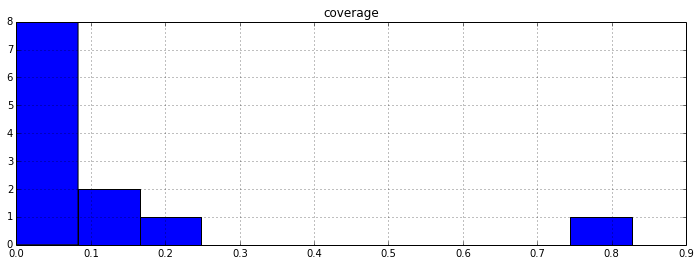

In [442]:
lf_stats = training_set.lf_stats()
lf_stats[:5]
lf_stats.hist("coverage")

In [443]:
from snorkel.snorkel import Learner
import snorkel.learning
from snorkel.learning import LogReg

text_learner = Learner(training_set, model=LogReg())

# Splitting into CV and test set
n_half = len(gold_candidates)/2
test_candidates = gold_candidates[:n_half]
test_labels     = gold_labels[:n_half]
cv_candidates   = gold_candidates[n_half:]
cv_labels       = gold_labels[n_half:]

from snorkel.learning_utils import GridSearch
gs       = GridSearch(text_learner, ['mu', 'lf_w0'], [[1e-5, 1e-7],[1.0,2.0]])
gs_stats = gs.fit(cv_candidates, cv_labels)

Testing mu = 1.00e-05, lf_w0 = 1.00e+00
Begin training for rate=0.01, mu=1e-05
	Learning epoch = 0	Gradient mag. = 0.026016
	Learning epoch = 250	Gradient mag. = 0.031044
	Learning epoch = 500	Gradient mag. = 0.035296
	Learning epoch = 750	Gradient mag. = 0.040148
Final gradient magnitude for rate=0.01, mu=1e-05: 0.046
Applying LFs...
Featurizing...
Testing mu = 1.00e-05, lf_w0 = 2.00e+00
Begin training for rate=0.01, mu=1e-05
	Learning epoch = 0	Gradient mag. = 0.044448
	Learning epoch = 250	Gradient mag. = 0.050086
	Learning epoch = 500	Gradient mag. = 0.053524
	Learning epoch = 750	Gradient mag. = 0.057059
Final gradient magnitude for rate=0.01, mu=1e-05: 0.061
Testing mu = 1.00e-07, lf_w0 = 1.00e+00
Begin training for rate=0.01, mu=1e-07
	Learning epoch = 0	Gradient mag. = 0.026016
	Learning epoch = 250	Gradient mag. = 0.031063
	Learning epoch = 500	Gradient mag. = 0.035338
	Learning epoch = 750	Gradient mag. = 0.040213
Final gradient magnitude for rate=0.01, mu=1e-07: 0.046
Testin

In [444]:
gs_stats

,mu,lf_w0,Prec.,Rec.,F1
0,0.00001,1,0.75,0.972973,0.847059
1,0.00001,2,0.75,0.972973,0.847059
2,0.00000,1,0.75,0.972973,0.847059
3,0.00000,2,0.75,0.972973,0.847059


In [445]:
text_learner.test_wmv(test_candidates, test_labels)

Applying LFs...
Featurizing...
Test set size:	179
----------------------------------------
Precision:	0.5
Recall:		1.0
F1 Score:	0.666666666667
----------------------------------------
TP: 37 | FP: 37 | TN: 105 | FN: 0


In [446]:
text_preds = text_learner.predict_wmv(text_c)
text_acronyms = [spairtxt2uid(c) for (c, p) in zip(text_c, text_preds) if p == 1]
print text_acronyms[:10]
mislabeled_cand = [(c,p, annotations.get(spair2uid(c), None)) for c, p in zip(text_c, text_preds) if p != annotations.get(spair2uid(c), p)]
for (c,p,g) in mislabeled_cand[:50]:
    _, phen, acro = spairtxt2uid(c)
    print c.span0.context.document.name, p, g
    print c.span0.context    
    print c.span0.get_span(), c.span1.get_span()
    print [LF(c) for LF in LF_txt]
    print

Applying LFs...
Featurizing...
[('17903292', u'Glomerular Filtration Rate', u'GFR'), ('17903292', u'Glomerular Filtration Rate', u'GFR'), ('17903292', u'Thyroid stimulation hormone', u'TSH'), ('17903292', u'Thyroid stimulation hormone', u'TSH'), ('17903292', u'Dehydroepiandrosterone sulfate', u'DHEAS'), ('17903292', u'Physical Location', u'Mb'), ('17903292', u'Physical Location', u'Mb'), ('17903292', u'Physical Location', u'Mb'), ('17903292', u'Physical Location', u'Mb'), ('17903292', u'Physical location', u'Mb')]
17903292 1.0 -1
Phrase('17903292', 1, 3, 0, u'Physical Location (Mb)')
Physical Location (Mb) (Mb)
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]

17903292 1.0 -1
Phrase('17903292', 1, 3, 0, u'Physical Location (Mb)')
Physical Location (Mb) (Mb)
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]

17903292 1.0 -1
Phrase('17903292', 1, 189, 0, u'Physical Location (Mb)')
Physical Location (Mb) (Mb)
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]

17903292 1.0 -1
Phrase('17903292', 1, 189, 0, u'Physical Location (

In [452]:
for (c) in (candidates):
#     if c.span0.context.document.name != '17903294': continue
    _, phen, acro = spairtxt2uid(c)
    print c.span0.context.document.name
    print c.span0.context    
    print c.span0.get_span(), c.span1.get_span()
    print [LF(c) for LF in LF_txt]
    print

17903293
Phrase('17903293', 0, 8, 0, u'CD40 Ligand, serum & plasma')
CD40 Ligand, serum & plasma CD40L
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, -1]

17903293
Phrase('17903293', 0, 10, 0, u'2')
2 CD40L
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, -1, 0]

17903293
Phrase('17903293', 0, 14, 0, u'C-reactive protein')
C-reactive protein CRP
[0, 0, 0, 0, 0, 1, 0, 0, -1, 0, 0, 0]

17903293
Phrase('17903293', 0, 16, 0, u'5')
5 CRP
[0, 0, 0, 0, 0, 1, 0, 0, -1, 0, -1, 0]

17903293
Phrase('17903293', 0, 20, 0, u'Intercellular adhesion molecule-1')
Intercellular adhesion molecule-1 ICAM1
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]

17903293
Phrase('17903293', 0, 22, 0, u'1')
1 ICAM1
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, -1, 0]

17903293
Phrase('17903293', 0, 26, 0, u'Interleukin-6')
Interleukin-6 IL6
[0, 0, 0, 0, 0, 1, 0, 0, -1, 0, 0, 0]

17903293
Phrase('17903293', 0, 28, 0, u'1')
1 IL6
[0, 0, 0, 0, 0, 1, 0, 0, -1, 0, -1, 0]

17903293
Phrase('17903293', 0, 32, 0, u'Urinary isoprostanes/creatinine')
Urinary isoprostanes/creatinine 

### Collect all the candidates

In [448]:
table_preds = learner.predict_wmv(candidates)
table_acronyms = [spair2uid(c) for (c, p) in zip(candidates, preds) if p == 1]
print table_acronyms[:10]

text_preds = text_learner.predict_wmv(text_c)
text_acronyms = [spairtxt2uid(c) for (c, p) in zip(text_c, text_preds) if p == 1]
print text_acronyms[:10]

acronyms = table_acronyms + text_acronyms

Applying LFs...
Featurizing...
[('17903293', u'CD40 Ligand, serum & plasma', u'CD40L'), ('17903293', u'C-reactive protein', u'CRP'), ('17903293', u'Intercellular adhesion molecule-1', u'ICAM1'), ('17903293', u'Interleukin-6', u'IL6'), ('17903293', u'Urinary isoprostanes/creatinine', u'IsoCrUrine'), ('17903293', u'Monocyte chemoattractant protein-1', u'MCP1'), ('17903293', u'Myeloperoxidase', u'MPO'), ('17903293', u'Osteoprotegerin', u'OPG'), ('17903293', u'P-selectin', u'Pselectin'), ('17903293', u'Tumor necrosis factor alpha', u'TNFA')]
Applying LFs...
Featurizing...
[('17903292', u'Glomerular Filtration Rate', u'GFR'), ('17903292', u'Glomerular Filtration Rate', u'GFR'), ('17903292', u'Thyroid stimulation hormone', u'TSH'), ('17903292', u'Thyroid stimulation hormone', u'TSH'), ('17903292', u'Dehydroepiandrosterone sulfate', u'DHEAS'), ('17903292', u'Physical Location', u'Mb'), ('17903292', u'Physical Location', u'Mb'), ('17903292', u'Physical Location', u'Mb'), ('17903292', u'Physica

In [449]:
# store relations to annotate
with open('acronyms.extracted.tsv', 'w') as f:
    for doc_id, str1, str2 in acronyms:
        try:
            out = u'{}\t{}\t{}\n'.format(doc_id, unicode(str1), str2)
            f.write(out.encode("UTF-8"))
        except:
            print 'ERROR:', str1, str2